In [89]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import (
    StratifiedKFold,
    GridSearchCV,
    cross_val_score,
    cross_val_predict
)
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    classification_report
)

from sklearn.feature_selection import mutual_info_classif
from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBClassifier


class MISupervisedSelector(BaseEstimator, TransformerMixin):
    """
    Supervised feature selection using mutual information.
    - Keeps ALWAYS_KEEP features
    - Adds top k_other additional features by MI
    - Designed to sit inside a sklearn Pipeline (no CV leakage).
    """
    def __init__(self, k_other=40, always_keep=None, random_state=42):
        self.k_other = k_other
        self.always_keep = always_keep if always_keep is not None else []
        self.random_state = random_state

    def fit(self, X, y):
        X = pd.DataFrame(X)
        self.feature_names_in_ = np.array(X.columns)

        # which columns are always kept
        keep_mask = np.isin(self.feature_names_in_, self.always_keep)
        keep_idx = np.where(keep_mask)[0]

        # impute just for MI calculation
        imp = SimpleImputer(strategy="median")
        X_imp = imp.fit_transform(X)

        mi = mutual_info_classif(X_imp, y, random_state=self.random_state)

        # only rank non-kept features
        non_keep_idx = np.where(~keep_mask)[0]
        mi_non_keep = mi[non_keep_idx]

        order = np.argsort(mi_non_keep)[::-1]  # descending
        order = order[: self.k_other]

        selected_non_keep_idx = non_keep_idx[order]

        # union of always-keep + top-k MI features
        final_idx = sorted(set(keep_idx) | set(selected_non_keep_idx))

        self.selected_mask_ = np.zeros_like(mi, dtype=bool)
        self.selected_mask_[final_idx] = True
        self.selected_features_ = self.feature_names_in_[self.selected_mask_]

        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X.loc[:, self.selected_features_]
        else:
            return X[:, self.selected_mask_]


# File/column names
TRAIN_FILE = "TrainDataset2025.xls"
ID_COL      = "ID"
TARGET_PCR  = "pCR (outcome)"
TARGET_RFS  = "RelapseFreeSurvival (outcome)"


Train shape: (400, 121)


,ID,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,TRG002174,1,144.0,41.0,0,0,0,1,3,3,...,0.517172,0.375126,3.325332,0.002314,3880771.500,473.464852,0.000768,0.182615,0.030508,0.000758
1,TRG002178,0,142.0,39.0,1,1,0,0,3,3,...,0.444391,0.444391,3.032144,0.005612,2372009.744,59.459710,0.004383,0.032012,0.001006,0.003685
2,TRG002204,1,135.0,31.0,0,0,0,1,2,1,...,0.534549,0.534549,2.485848,0.006752,1540027.421,33.935384,0.007584,0.024062,0.000529,0.006447
3,TRG002206,0,12.0,35.0,0,0,0,1,3,3,...,0.506185,0.506185,2.606255,0.003755,6936740.794,46.859265,0.005424,0.013707,0.000178,0.004543
4,TRG002210,0,109.0,61.0,1,0,0,0,2,1,...,0.462282,0.462282,2.809279,0.006521,1265399.054,39.621023,0.006585,0.034148,0.001083,0.005626


X shape: (395, 118)
y_pcr shape: (395,)
Unique PCR values: [1 0]
Class counts -> negative: 311, positive: 84
Imbalance ratio (neg:pos) = 311 : 84
scale_pos_weight ≈ 3.70


/var/folders/35/vxjl_n4s1xg11npkpzsxjjkc0000gn/T/ipykernel_4005/1050318032.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="Blues_d")


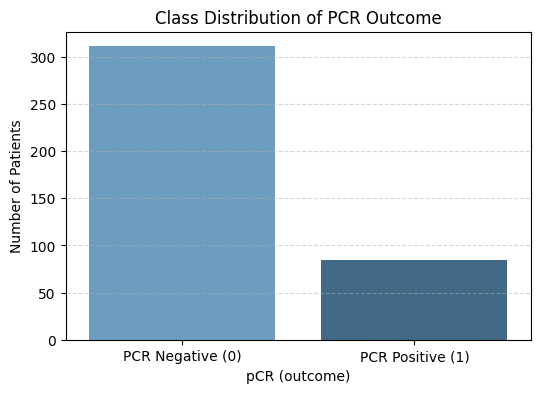

In [90]:
# Load train data
df_train = pd.read_excel(TRAIN_FILE, na_values=[999])

print("Train shape:", df_train.shape)
display(df_train.head())

# Ensure PCR is numeric and clean
df_train[TARGET_PCR] = pd.to_numeric(df_train[TARGET_PCR], errors="coerce")
df_train.loc[df_train[TARGET_PCR] == 999, TARGET_PCR] = np.nan

# Drop rows with missing PCR
df_train = df_train.dropna(subset=[TARGET_PCR])

# Features: drop ID and both outcome columns (NO leakage)
X = df_train.drop(columns=[ID_COL, TARGET_PCR, TARGET_RFS])
y_pcr = df_train[TARGET_PCR].astype(int)

print("X shape:", X.shape)
print("y_pcr shape:", y_pcr.shape)
print("Unique PCR values:", y_pcr.unique())

# Class imbalance
n_pos = (y_pcr == 1).sum()
n_neg = (y_pcr == 0).sum()
scale_pos_weight = n_neg / n_pos

print(f"Class counts -> negative: {n_neg}, positive: {n_pos}")
print(f"Imbalance ratio (neg:pos) = {n_neg} : {n_pos}")
print(f"scale_pos_weight ≈ {scale_pos_weight:.2f}")

# Plot class distribution
class_counts = y_pcr.value_counts().sort_index()
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="Blues_d")
plt.xticks([0, 1], ["PCR Negative (0)", "PCR Positive (1)"])
plt.ylabel("Number of Patients")
plt.title("Class Distribution of PCR Outcome")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


In [91]:
# Always-keep clinical features
ALWAYS_KEEP = ["ER", "HER2", "Gene"]

# 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ------- SVM pipeline -------
# SVM likes a bit more dimensionality – use larger k_other
svm_rbf = Pipeline([
    ("feat_sel", MISupervisedSelector(k_other=120, always_keep=ALWAYS_KEEP)),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="rbf",
        class_weight="balanced",
        probability=True,
        random_state=42
    ))
])

# ------- XGBoost pipeline -------
# XGBoost seems to prefer a more compact feature set
xgb_clf = Pipeline([
    ("feat_sel", MISupervisedSelector(k_other=40, always_keep=ALWAYS_KEEP)),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        n_estimators=400,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        tree_method="hist",
        random_state=42,
        n_jobs=-1
    ))
])


In [92]:
# ---------- SVM baseline ----------
svm_baseline_scores = cross_val_score(
    svm_rbf,
    X,
    y_pcr,
    cv=cv,
    scoring="balanced_accuracy",
    n_jobs=-1
)

print(f"Baseline RBF SVM BA: {svm_baseline_scores.mean():.4f} "
      f"± {svm_baseline_scores.std():.4f}")

svm_param_grid = {
    "svm__C": [0.1, 1, 10, 50, 100],
    "svm__gamma": ["scale", 0.01, 0.001, 0.0001]
}

svm_grid = GridSearchCV(
    svm_rbf,
    svm_param_grid,
    cv=cv,
    scoring="balanced_accuracy",
    n_jobs=-1,
    verbose=2
)

svm_grid.fit(X, y_pcr)

print("Best SVM balanced accuracy:", svm_grid.best_score_)
print("Best SVM params:", svm_grid.best_params_)

best_svm = svm_grid.best_estimator_


# ---------- XGBoost baseline ----------
xgb_baseline_scores = cross_val_score(
    xgb_clf,
    X,
    y_pcr,
    cv=cv,
    scoring="balanced_accuracy",
    n_jobs=-1
)

print("\nBaseline XGBoost BA:",
      f"{xgb_baseline_scores.mean():.4f} ± {xgb_baseline_scores.std():.4f}")

xgb_param_grid = {
    "xgb__n_estimators": [300, 600],
    "xgb__max_depth": [3, 5],
    "xgb__learning_rate": [0.03, 0.1],
    "xgb__subsample": [0.7, 1.0],
    "xgb__colsample_bytree": [0.7, 1.0],
    "xgb__scale_pos_weight": [scale_pos_weight, scale_pos_weight * 1.5]
}

xgb_grid = GridSearchCV(
    xgb_clf,
    xgb_param_grid,
    cv=cv,
    scoring="balanced_accuracy",
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X, y_pcr)

print("Best XGBoost balanced accuracy:", xgb_grid.best_score_)
print("Best XGBoost params:", xgb_grid.best_params_)

best_xgb = xgb_grid.best_estimator_


Baseline RBF SVM BA: 0.6486 ± 0.0496
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END .......................svm__C=0.1, svm__gamma=scale; total time=   0.8s
[CV] END .......................svm__C=0.1, svm__gamma=scale; total time=   0.8s
[CV] END .......................svm__C=0.1, svm__gamma=scale; total time=   0.8s
[CV] END .......................svm__C=0.1, svm__gamma=scale; total time=   0.8s
[CV] END .......................svm__C=0.1, svm__gamma=scale; total time=   0.8s
[CV] END ........................svm__C=0.1, svm__gamma=0.01; total time=   0.8s
[CV] END ........................svm__C=0.1, svm__gamma=0.01; total time=   0.8s
[CV] END ........................svm__C=0.1, svm__gamma=0.01; total time=   0.8s
[CV] END ........................svm__C=0.1, svm__gamma=0.01; total time=   0.8s
[CV] END .......................svm__C=0.1, svm__gamma=0.001; total time=   0.8s
[CV] END .......................svm__C=0.1, svm__gamma=0.001; total time=   0.8s
[CV] END .

In [93]:
# ---- Threshold tuning + CV evaluation for BOTH SVM and XGBoost ----

thresholds = np.linspace(0.1, 0.9, 81)  # 0.10, 0.11, ..., 0.90

def tune_model_threshold(model, name):
    """
    For a fitted Pipeline (model):
    - Get cross-validated probabilities
    - Find threshold that maximises balanced accuracy
    - Return metrics & ROC info
    """
    proba_cv = cross_val_predict(
        model,
        X,
        y_pcr,
        cv=cv,
        method="predict_proba",
        n_jobs=-1
    )
    scores = proba_cv[:, 1]

    best_thr = 0.5
    best_ba = -1.0

    for thr in thresholds:
        y_pred_thr = (scores >= thr).astype(int)
        ba_thr = balanced_accuracy_score(y_pcr, y_pred_thr)
        if ba_thr > best_ba:
            best_ba = ba_thr
            best_thr = thr

    print(f"[{name}] best threshold for balanced accuracy: {best_thr:.3f}")
    print(f"[{name}] balanced accuracy at best threshold: {best_ba:.4f}")

    # final predictions at best threshold
    y_pred = (scores >= best_thr).astype(int)

    # confusion matrix + ROC data
    cm = confusion_matrix(y_pcr, y_pred, labels=[0, 1])
    fpr, tpr, _ = roc_curve(y_pcr, scores)
    auc = roc_auc_score(y_pcr, scores)

    # classification report as dict for later summary
    report = classification_report(
        y_pcr,
        y_pred,
        target_names=["PCR Negative", "PCR Positive"],
        output_dict=True
    )

    return {
        "proba": scores,
        "best_thr": best_thr,
        "best_ba": best_ba,
        "y_pred": y_pred,
        "cm": cm,
        "fpr": fpr,
        "tpr": tpr,
        "auc": auc,
        "report": report,
    }

# SVM results
svm_results = tune_model_threshold(best_svm, "SVM")

# XGBoost results
xgb_results = tune_model_threshold(best_xgb, "XGBoost")

# Unpack SVM
svm_best_thr = svm_results["best_thr"]
svm_best_ba = svm_results["best_ba"]
svm_y_pred = svm_results["y_pred"]
svm_cm = svm_results["cm"]
svm_fpr = svm_results["fpr"]
svm_tpr = svm_results["tpr"]
svm_roc_auc = svm_results["auc"]
svm_report_dict = svm_results["report"]

# Unpack XGBoost (and keep some names backwards-compatible)
xgb_best_thr = xgb_results["best_thr"]
xgb_best_ba = xgb_results["best_ba"]
y_pred = xgb_results["y_pred"]          # XGBoost predictions
cm = xgb_results["cm"]
fpr = xgb_results["fpr"]
tpr = xgb_results["tpr"]
roc_auc = xgb_results["auc"]
xgb_report_dict = xgb_results["report"]

print("\n[XGBoost] Balanced Accuracy (CV preds, tuned threshold "
      f"{xgb_best_thr:.3f}): {xgb_best_ba:.4f}")
print("[SVM]     Balanced Accuracy (CV preds, tuned threshold "
      f"{svm_best_thr:.3f}): {svm_best_ba:.4f}")


[SVM] best threshold for balanced accuracy: 0.240
[SVM] balanced accuracy at best threshold: 0.6532
[XGBoost] best threshold for balanced accuracy: 0.130
[XGBoost] balanced accuracy at best threshold: 0.7090

[XGBoost] Balanced Accuracy (CV preds, tuned threshold 0.130): 0.7090
[SVM]     Balanced Accuracy (CV preds, tuned threshold 0.240): 0.6532



Classification report (XGBoost):
              precision    recall  f1-score   support

PCR Negative       0.94      0.54      0.68       311
PCR Positive       0.34      0.88      0.49        84

    accuracy                           0.61       395
   macro avg       0.64      0.71      0.59       395
weighted avg       0.82      0.61      0.64       395



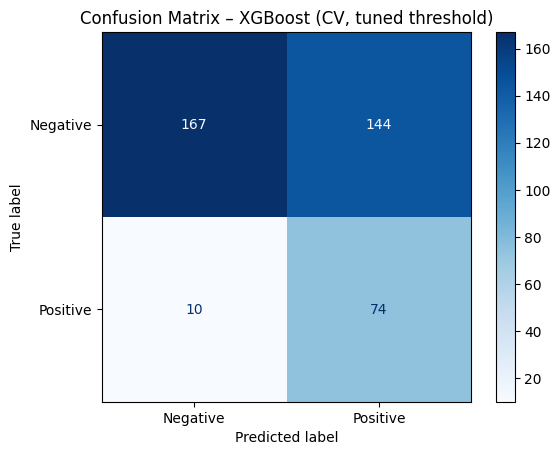

ROC AUC (XGBoost, tuned threshold): 0.7503


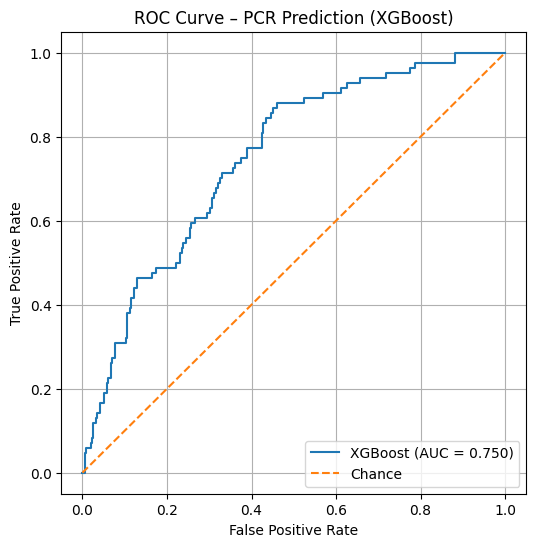

In [94]:
print("\nClassification report (XGBoost):")
print(classification_report(
    y_pcr,
    y_pred,   # XGBoost predictions from xgb_results
    target_names=["PCR Negative", "PCR Positive"]
))

# Confusion matrix for XGBoost
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – XGBoost (CV, tuned threshold)")
plt.show()

# ROC / AUC using CV probabilities (XGBoost)
print(f"ROC AUC (XGBoost, tuned threshold): {roc_auc:.4f}")

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – PCR Prediction (XGBoost)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


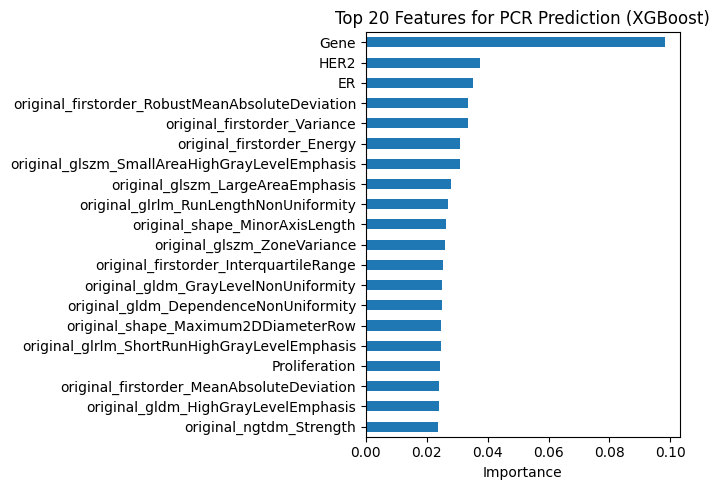

In [95]:
# Fit best_xgb on all data for interpretability & later test prediction
best_xgb.fit(X, y_pcr)

# Get selected features from the feature selector step
feat_sel = best_xgb.named_steps["feat_sel"]
selected_features = feat_sel.selected_features_

xgb_model = best_xgb.named_steps["xgb"]
importances = pd.Series(xgb_model.feature_importances_, index=selected_features)

top20 = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(7, 5))
top20.sort_values().plot(kind="barh")
plt.xlabel("Importance")
plt.title("Top 20 Features for PCR Prediction (XGBoost)")
plt.tight_layout()
plt.show()


In [96]:
TEST_FILE_FINAL = "TestDatasetExample.xls"  # change to real test file name on release

df_test_final = pd.read_excel(TEST_FILE_FINAL, na_values=[999])

# Keep IDs
test_ids = df_test_final[ID_COL].values

# Use SAME feature columns as training X (selector will choose subset internally)
X_test_final = df_test_final[X.columns]

# Ensure model is trained on all training data
best_xgb.fit(X, y_pcr)

# Predict probabilities and apply tuned XGBoost threshold
test_proba = best_xgb.predict_proba(X_test_final)[:, 1]
test_pred = (test_proba >= xgb_best_thr).astype(int)

# Build and save CSV
out_df = pd.DataFrame({
    "ID": test_ids,
    "PCR": test_pred.astype(int)
})

out_df.to_csv("PCRPrediction.csv", index=False)
out_df.head()


,ID,PCR
0,TRG002728,0
1,TRG002649,1
2,TRG002628,1


In [97]:
print("==== MODEL & CV PERFORMANCE (GridSearchCV) ====")
print(f"SVM      best balanced accuracy (CV): {svm_grid.best_score_:.4f}")
print(f"SVM      best params: {svm_grid.best_params_}")
print()
print(f"XGBoost  best balanced accuracy (CV): {xgb_grid.best_score_:.4f}")
print(f"XGBoost  best params: {xgb_grid.best_params_}")
print()

print("==== THRESHOLD-TUNED PERFORMANCE (using CV probabilities) ====")
print(f"SVM      tuned threshold: {svm_best_thr:.3f}, "
      f"balanced accuracy: {svm_best_ba:.4f}, ROC AUC: {svm_roc_auc:.4f}")
print(f"XGBoost  tuned threshold: {xgb_best_thr:.3f}, "
      f"balanced accuracy: {xgb_best_ba:.4f}, ROC AUC: {roc_auc:.4f}")
print()

# Confusion matrices
svm_tn, svm_fp, svm_fn, svm_tp = svm_cm.ravel()
xgb_tn, xgb_fp, xgb_fn, xgb_tp = cm.ravel()

print("==== CONFUSION MATRIX (CV, tuned threshold) ====")
print("SVM:")
print(f"  TN: {svm_tn}, FP: {svm_fp}, FN: {svm_fn}, TP: {svm_tp}")
print("XGBoost:")
print(f"  TN: {xgb_tn}, FP: {xgb_fp}, FN: {xgb_fn}, TP: {xgb_tp}")
print()

# Helper to print class metrics from report dict
def print_class_metrics(name, report_dict):
    print(f"{name}:")
    for cls in ["PCR Negative", "PCR Positive"]:
        prec = report_dict[cls]["precision"]
        rec  = report_dict[cls]["recall"]
        f1   = report_dict[cls]["f1-score"]
        support = report_dict[cls]["support"]
        print(f"  {cls}: precision={prec:.3f}, recall={rec:.3f}, "
              f"F1={f1:.3f}, support={support}")
    print(f"  Macro avg F1:    {report_dict['macro avg']['f1-score']:.3f}")
    print(f"  Weighted avg F1: {report_dict['weighted avg']['f1-score']:.3f}")
    print()

print("==== PER-CLASS METRICS ====")
print_class_metrics("SVM", svm_report_dict)
print_class_metrics("XGBoost", xgb_report_dict)


==== MODEL & CV PERFORMANCE (GridSearchCV) ====
SVM      best balanced accuracy (CV): 0.6486
SVM      best params: {'svm__C': 1, 'svm__gamma': 'scale'}

XGBoost  best balanced accuracy (CV): 0.6604
XGBoost  best params: {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.03, 'xgb__max_depth': 3, 'xgb__n_estimators': 300, 'xgb__scale_pos_weight': np.float64(5.553571428571429), 'xgb__subsample': 0.7}

==== THRESHOLD-TUNED PERFORMANCE (using CV probabilities) ====
SVM      tuned threshold: 0.240, balanced accuracy: 0.6532, ROC AUC: 0.6702
XGBoost  tuned threshold: 0.130, balanced accuracy: 0.7090, ROC AUC: 0.7503

==== CONFUSION MATRIX (CV, tuned threshold) ====
SVM:
  TN: 236, FP: 75, FN: 38, TP: 46
XGBoost:
  TN: 167, FP: 144, FN: 10, TP: 74

==== PER-CLASS METRICS ====
SVM:
  PCR Negative: precision=0.861, recall=0.759, F1=0.807, support=311.0
  PCR Positive: precision=0.380, recall=0.548, F1=0.449, support=84.0
  Macro avg F1:    0.628
  Weighted avg F1: 0.731

XGBoost:
  PCR Negat